# MCMC Advanced Topics

Here are are going to deal with more complex data problems: outliers and errors in both the x- and y-axes. First, let's load up the libraries we are going to need

In [286]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

import emcee
import corner


%matplotlib inline

### Let's review the basics: fitting a line to data

We'll start with a demonstrative example using a dataset taken from the pedagogical manuscript [Data analysis recipes: Fitting a model to data](https://arxiv.org/pdf/1008.4686.pdf). This data has all the characteristics to make the problem interesting.

In [287]:
data = np.load("Hogg_2010_example.npy")

print("There are %i"%len(data) + " rows in the dataset")

print(data.dtype.names)
for line in data:
    print(line)

There are 20 rows in the dataset
('x', 'y', 'x_err', 'y_err', 'rho_xy')
(201., 592., 9., 61., -0.84)
(244., 401., 4., 25., 0.31)
(47., 583., 11., 38., 0.64)
(287., 402., 7., 15., -0.27)
(203., 495., 5., 21., -0.33)
(58., 173., 9., 15., 0.67)
(210., 479., 4., 27., -0.02)
(202., 504., 4., 14., -0.05)
(198., 510., 11., 30., -0.84)
(158., 416., 7., 16., -0.69)
(165., 393., 5., 14., 0.3)
(201., 442., 5., 25., -0.46)
(157., 317., 5., 52., -0.03)
(131., 311., 6., 16., 0.5)
(166., 400., 6., 34., 0.73)
(160., 337., 5., 31., -0.52)
(186., 423., 9., 42., 0.9)
(125., 334., 8., 26., 0.4)
(218., 533., 6., 16., -0.78)
(146., 344., 5., 22., -0.56)


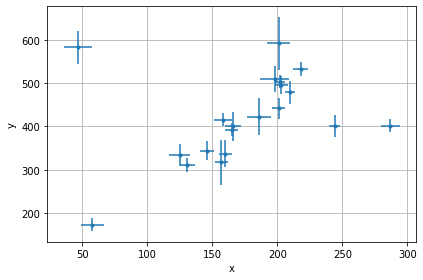

In [288]:
plt.errorbar(data['x'], data['y'], xerr=data['x_err'], yerr=data['y_err'], marker='.', fmt='o', zorder=10)

plt.xlabel('x')
plt.ylabel('y')

plt.grid()

plt.tight_layout()
plt.show()

So you'll notice that we have data with x- and y-axis values that have error bars in both dimensions as well as covariance between the error bars. The goal is to fit a line to this data. 

### 1. As first (incorrect) approximation, let's ignore the x-error bars

Let's start by defining our likelihood function:

$$ \mathcal{L} = \frac{1}{\sqrt{2 \pi \sigma^2_{y_i}}} \exp\left[ - \frac{(y_i - y(x))^2}{2 \sigma^2_{y_i}} \right], $$
where $y(x)$ is our linear model: 

$$ y(x) = mx + b $$

Code up a function that returns the sum of the log of the likelihood in the code block below:

In [289]:
def ln_likelihood(p, data):
    
    m, b = p
    
    model_y = m*data['x'] + b

    likelihood = 1/np.sqrt(2*np.pi*data['y_err']**2) * np.exp(-(data['y'] - model_y)**2 / (2 * data['y_err']**2))
    
    return sum(np.log(likelihood))


Now, we can feed this function into `emcee` to find the best fit line

In [290]:
ndim = 2
nwalkers = 32

# Let's give the code a reasonable starting point
starting_point = [2.2, 50]

# Generate the initial point for the walkers
p0 = np.zeros((nwalkers, ndim))
p0 = np.random.normal(loc=1, scale=1.0e-2, size=(nwalkers, ndim)) * starting_point

# Create the sampler object
sampler = emcee.EnsembleSampler(nwalkers, ndim, ln_likelihood, args=[data])

# Run the sampler
state = sampler.run_mcmc(p0, 2000)

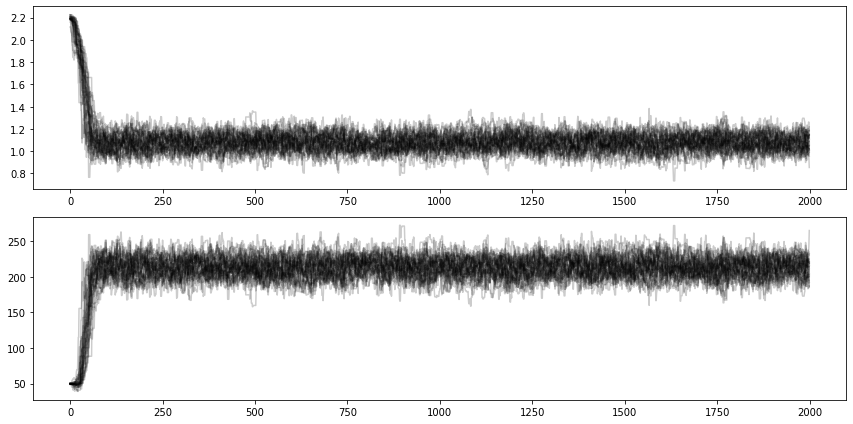

In [291]:
fig, ax = plt.subplots(ndim, 1, figsize=(12, 6))

for i in range(ndim):
    for j in range(nwalkers):
        ax[i].plot(sampler.chain[j,:,i], alpha=0.2, color='k')

plt.tight_layout()
plt.show()

Now, let's take a look at the distribution of and covariance between the model parameters

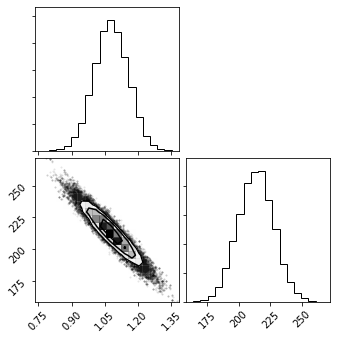

In [292]:
# Remove burn-in
chains = sampler.chain[:,200:]

# Flatten the chains
n_chains, n_steps, n_var = chains.shape
flatchain = chains.reshape((n_chains*n_steps, n_var))

corner.corner(flatchain)

plt.show()

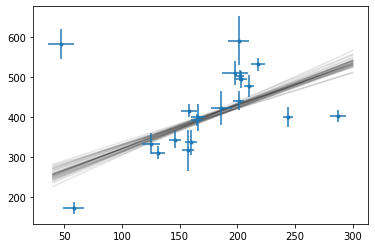

In [293]:
idx = np.random.randint(0, len(flatchain), size=30)
samples = flatchain[idx]

plt.errorbar(data['x'], data['y'], xerr=data['x_err'], yerr=data['y_err'], marker='.', fmt='o', zorder=10)

tmp_x = np.linspace(40, 300, 100)
for sample in samples:
    m = sample[0]
    b = sample[1]
    plt.plot(tmp_x, m*tmp_x+b, color='k', alpha=0.1)


plt.show()

### 2. Dealing with outliers: a mixture model

Now, things get interesting. To deal with outliers, we are going to add a bunch of variables to our model. First, we will add one variable $q_i$ for every data point, which is either a 0 or a 1, corresponding to whether that point is an outlier or not. 

We will additionally add a model for our outliers. In this case we'll use a simple model described by a Gaussian in the $y$-axis only, which includes two extra dimensions: a mean, $Y_b$, and a variance, $V_b$. 

Finally, there is a parameter $P_b$, constrained to be between 0 and 1 that indicates the fraction of our data points that are part of the background. 

Combined, our model now has $N+5$ model parameters ($m$, $b$, $\{q_i\}_{i=1}^{N}$, $P_b$, $Y_b$, $V_b$), where $N$ is the number of data points. Note that it is not a problem for our model to have more parameters than data points.

Now, our likelihood is more complex and is comprised of two parts: one for the source and one for the background:

$$ \mathcal{L} = \prod_{i=1}^N P_{\rm background}(y_i|P_b, Y_b, V_b)^{1-q_i}\ P_{\rm source}(y_i|m, b)^{q_i} $$

Our background model is a Gaussian in $y$ only, so

$$ P_{\rm background}(y_i|P_b, Y_b, V_b) = \frac{1}{\sqrt{2 \pi (\sigma_{y_i}^2 + V_b)}} \exp \left[ - \frac{(y_i - Y_b)^2}{2 (\sigma_{y_i}^2 + V_b)} \right] $$

and our likelihood for the model is unchanged from before:

$$ P_{\rm source}(y_i|m, b) = \frac{1}{\sqrt{2 \pi \sigma_{y_i}^2}} \exp \left[ - \frac{(y_i - f(y))^2}{2 \sigma_{y_i}^2} \right] $$

How do we deal with a model with so many parameters? Well, luckily, most of these can be marginalized out. Let's see how. From Bayesian calculus, we can factor our likelihood:

$$ 
\begin{aligned}
 P(m, b, \{q_i\}_{i=1}^{N}, P_b, Y_b, V_b) =& P(\{q_i\}_{i=1}^{N} | m, b, P_b, Y_b, V_b)\  P(m, b, P_b, Y_b, V_b) \\
    =& P(\{q_i\}_{i=1}^{N} | P_b)\ P(m, b, P_b, Y_b, V_b) \\
 \end{aligned}
$$

Where we have made the realization that each of the $q_i$'s depends only on $P_b$. We can remove all the $q_i$'s by analytically integrating over them (really a sum over each q_i being equal to 0 or 1). Through some math, which I will not entirely reproduce here, we can arrive at a reduced form of the likelihood:


$$ \mathcal{L} = \prod_{i=1}^N P_b\ P_{\rm background}(y_i|P_b, Y_b, V_b) + (1-P_b)\ P_{\rm source}(y_i|m, b) $$

Code this new likelihood into a function below. I will provide the priors and posterior function:

In [294]:
def ln_likelihood_outliers(p, data):
    
    m, b, P_b, Y_b, V_b = p
    
    model_y = m * data['x'] + b
    y_err = data['y_err']
    
    likelihood = (1-P_b)/np.sqrt(2*np.pi*y_err**2) * np.exp(-(data['y'] - model_y)**2 / (2 * y_err**2))
    likelihood += P_b/np.sqrt(2*np.pi*(V_b + y_err)**2) * np.exp(-(data['y'] - Y_b)**2 / (2 * (V_b + y_err)**2))
    
    return sum(np.log(likelihood))




def ln_prior_outliers(p):
    
    m, b, P_b, Y_b, V_b = p
    
    if P_b < 0 or 1 < P_b: return -np.inf
    if V_b < 0 or V_b > 1000: return -np.inf
    
    return 0

def ln_posterior_outliers(p, data):

    lp = ln_prior_outliers(p)
    if np.isinf(lp): return -np.inf
    
    ll = ln_likelihood_outliers(p, data)
    if np.isnan(ll): return -np.inf

    return lp + ll
    

In [295]:
ndim = 5
nwalkers = 32

starting_point = [2.2, 50, 0.05, 300, 200]

p0 = np.zeros((nwalkers, ndim))
p0 = np.random.normal(loc=1, scale=1.0e-2, size=(nwalkers, ndim)) * starting_point

sampler = emcee.EnsembleSampler(nwalkers, ndim, ln_posterior_outliers, args=[data])

In [296]:
state = sampler.run_mcmc(p0, 2000)

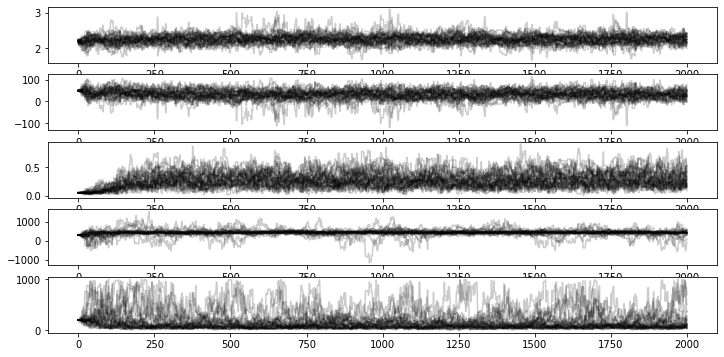

In [297]:
fig, ax = plt.subplots(ndim, 1, figsize=(12, 6))

for i in range(ndim):
    for j in range(nwalkers):
        ax[i].plot(sampler.chain[j,:,i], alpha=0.2, color='k')
        
plt.show()

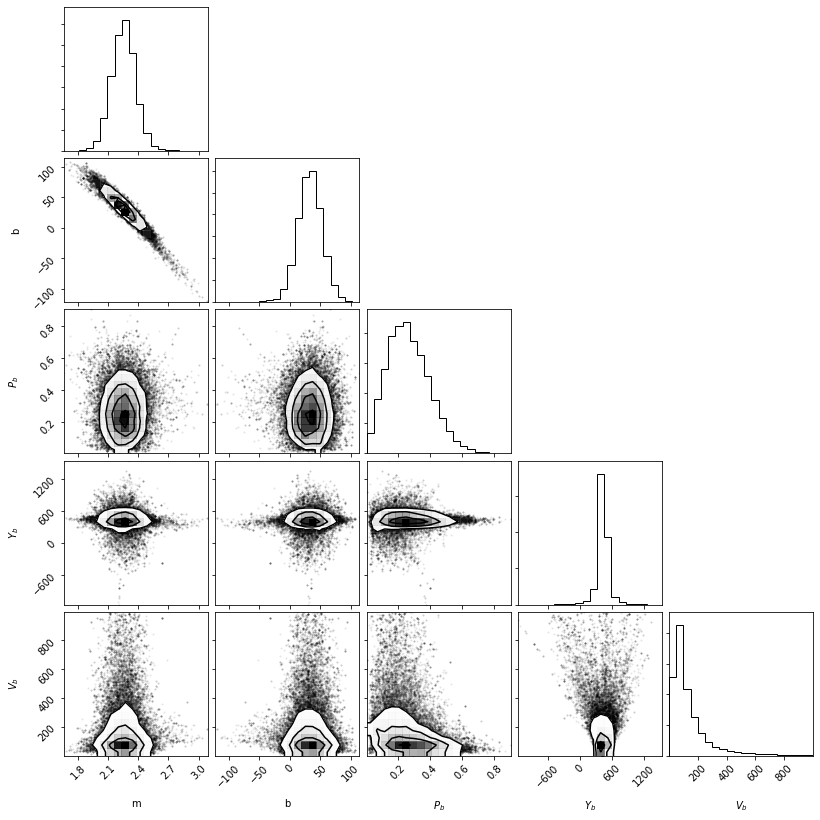

In [300]:
# Remove burn-in
chains = sampler.chain[:,200:]

# Flatten the chains
n_chains, n_steps, n_var = chains.shape
flatchain = chains.reshape((n_chains*n_steps, n_var))

labels = ['m', 'b', r'$P_b$', r'$Y_b$', r'$V_b$']
corner.corner(flatchain, labels=labels)

plt.show()

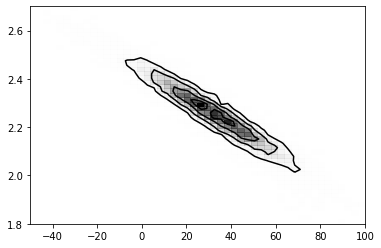

In [8]:
corner.hist2d(sampler.flatchain[:,1], sampler.flatchain[:,0], 
              range=((-50, 100), (1.8, 2.7)), bins=50, plot_datapoints=False)

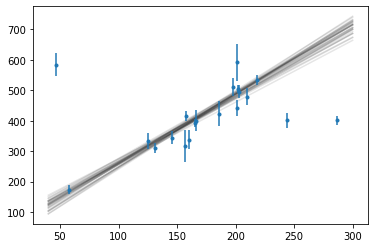

In [301]:
idx = np.random.randint(0, len(flatchain), size=30)
samples = flatchain[idx]

plt.errorbar(data['x'], data['y'], yerr=data['y_err'], marker='.', fmt='o', zorder=10)

tmp_x = np.linspace(40, 300, 100)
for sample in samples:
    m = sample[0]
    b = sample[1]
    plt.plot(tmp_x, m*tmp_x+b, color='k', alpha=0.1)


plt.show()

### And what about the fraction of points with outliers?

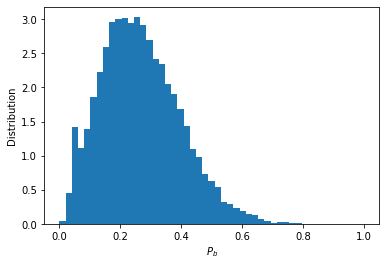

In [304]:
plt.hist(sampler.flatchain[:,2], bins=np.linspace(0, 1, 50), density=True)

plt.xlabel(r'$P_b$')
plt.ylabel('Distribution')

plt.show()

### 3. What about x-axis errors?

Here, we'll go back to our non-mixture model to come up with a treatment of errors on the x-axis. We'll do two things in this example. First, we'll switch from parameterizing our line as ($m$, $b$) into ($\theta$, $b_{\perp}$), where:

$$
\begin{aligned}
m =& \tan(\theta) \\
b_{\perp} =& b \cos(\theta)
\end{aligned}
$$

Second, we will rotate the covariance matrix of each observation by an angle $\theta$ so that the distance between our line and our model is in only one axis. To do this, we first define the unit vector orthogonal to the line:

$$ \hat{v} = \left[ \begin{array} -- \sin \theta \\ \cos \theta \end{array} \right] $$

Now, we'll define a vector with our data point:

$$ Z_i = \left[ \begin{array} -- x_i \\ y_i \end{array} \right] $$

Then, the distance from the line to any individual data point is:

$$ \Delta = \hat{v}^T Z_i - b \cos \theta $$

We're almost there. The last step is to project the data point's covariance matrix $S_i$,

$$ S_i = \left[ \begin{array}- \sigma_{x_i}^2 & \rho_{xy} \sigma_{x_i} \sigma_{y_i} \\ \rho_{xy} \sigma_{x_i} \sigma_{y_i} & \sigma_{y_i}^2 \end{array} \right] $$

into an orthogonal variance $\Sigma_i$, where:

$$ \Sigma_i^2 = \hat{v}^T S_i \hat{v} $$

Finally, the log of the likelihood can be written as:
$$ \ln \mathcal{L} = K - \sum_{i=1}^N \frac{\Delta_i^2}{2 \Sigma_i^2} $$

Even if you didn't entirely follow the linear algebra steps to get here, compare it to the likelihood equation above, and it should start to look familiar.

Since the matrix multiplication can be a bit tricky to get right in python, I am providing the likelihood code for you below.

In [305]:
def ln_likelihood_xyerr(p, data):

    theta, b_perp = p

    v_vec = np.mat(np.array([-np.sin(theta), np.cos(theta)])).T

    Z = np.mat(np.array([data['x'], data['y']]))

    delta = np.matmul(v_vec.T, Z) - b_perp
    delta = np.array(delta)[0]
    
    S = np.array([[data['x_err']**2, data['rho_xy']*data['x_err']*data['y_err']], 
                  [data['rho_xy']*data['x_err']*data['y_err'], data['y_err']**2]])
    S = np.swapaxes(S, 0, 2)
    
    sigma_2 = np.matmul(v_vec.T, np.matmul(S, v_vec).T)
    sigma_2 = np.array(sigma_2)[0]

    return -np.sum(delta**2 / (2*sigma_2))


def ln_prior_xyerr(p):
    
    theta, b_perp = p

    if theta > np.pi or theta < 0: return -np.inf
    
    return 0


def ln_posterior_xyerr(p, data):

    lp = ln_prior_xyerr(p)
    if np.isinf(lp): return -np.inf
    
    ll = ln_likelihood_xyerr(p, data)
    if np.isnan(ll): return -np.inf

    return lp + ll
    

### We will first run this model removing the first four points of our data set

It turns out that the first four data points are the outliers, so we are cheating here to make sure it works.

In [327]:
ndim = 2
nwalkers = 32


starting_point = [1.09, 36]

p0 = np.zeros((nwalkers, ndim))
p0 = np.random.normal(loc=1, scale=1.0e-4, size=(nwalkers, ndim)) * starting_point

sampler = emcee.EnsembleSampler(nwalkers, ndim, ln_posterior_xyerr, args=[data[4:]])

In [328]:
state = sampler.run_mcmc(p0, 500)
# sampler.reset()

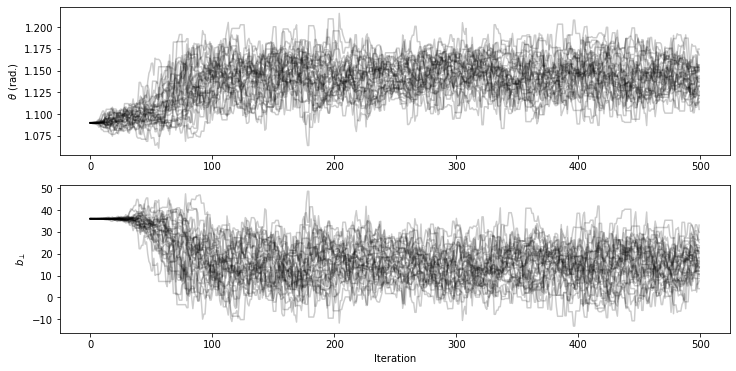

In [329]:
fig, ax = plt.subplots(ndim, 1, figsize=(12, 6))

for i in range(ndim):
    for j in range(nwalkers):
        ax[i].plot(sampler.chain[j,:,i], alpha=0.2, color='k')
        
ax[1].set_xlabel('Iteration')
ax[0].set_ylabel(r'$\theta$ (rad.)')
ax[1].set_ylabel(r'$b_{\perp}$')
        
plt.show()

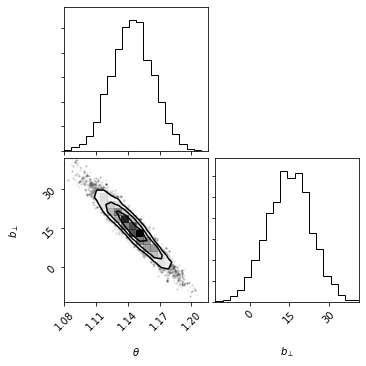

In [331]:
# Remove burn-in
chains = sampler.chain[:,200:]

# Flatten the chains
n_chains, n_steps, n_var = chains.shape
flatchain = chains.reshape((n_chains*n_steps, n_var))

labels = [r'$\theta$', r'$b_{\perp}$']
corner.corner(flatchain, labels=labels)

plt.show()

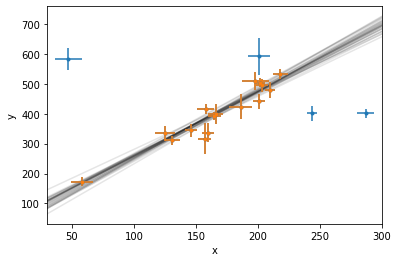

In [332]:
idx = np.random.randint(0, len(flatchain), size=30)
samples = flatchain[idx]

plt.errorbar(data['x'], data['y'], 
             xerr=data['x_err'], yerr=data['y_err'], 
             marker='.', fmt='o', zorder=10)

plt.errorbar(data['x'][4:], data['y'][4:], 
             xerr=data['x_err'][4:], yerr=data['y_err'][4:], 
             marker='.', fmt='o', zorder=10)


tmp_x = np.linspace(30, 300, 100)
for sample in samples:
    
    theta, b_perp = sample[0], sample[1]
    m = np.tan(theta)
    b = b_perp / np.cos(theta)
        
    plt.plot(tmp_x, m*tmp_x+b, color='k', alpha=0.1, zorder=1)
    
plt.xlabel('x')
plt.ylabel('y')

plt.xlim(30, 300)

plt.show()

### Now fit using all the data

In [333]:
ndim = 2
nwalkers = 64


starting_point = [1.09, 36]

p0 = np.zeros((nwalkers, ndim))
p0 = np.random.normal(loc=1, scale=1.0e-4, size=(nwalkers, ndim)) * starting_point

sampler = emcee.EnsembleSampler(nwalkers, ndim, ln_posterior_xyerr, args=[data])

In [334]:
state = sampler.run_mcmc(p0, 500)

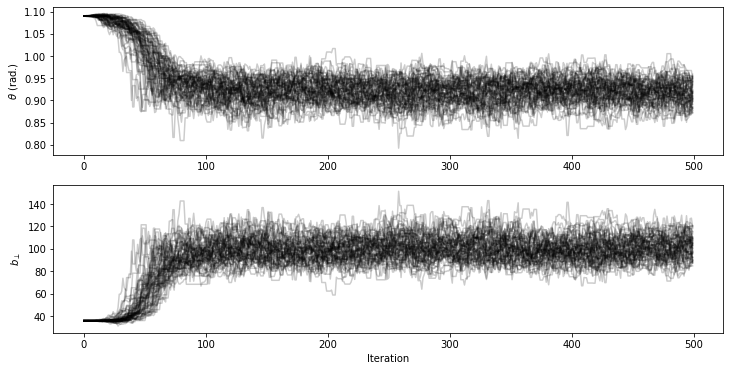

In [335]:
fig, ax = plt.subplots(ndim, 1, figsize=(12, 6))

for i in range(ndim):
    for j in range(nwalkers):
        ax[i].plot(sampler.chain[j,:,i], alpha=0.2, color='k')
        
ax[1].set_xlabel('Iteration')
ax[0].set_ylabel(r'$\theta$ (rad.)')
ax[1].set_ylabel(r'$b_{\perp}$')
        
plt.show()

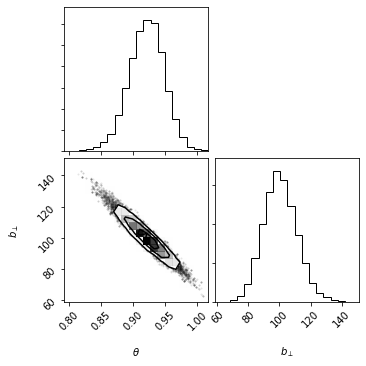

In [336]:
# Remove burn-in
chains = sampler.chain[:,200:]

# Flatten the chains
n_chains, n_steps, n_var = chains.shape
flatchain = chains.reshape((n_chains*n_steps, n_var))

labels = [r'$\theta$', r'$b_{\perp}$']
corner.corner(flatchain, labels=labels)

plt.show()

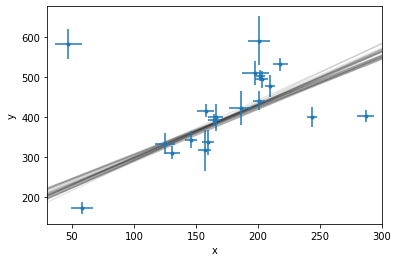

In [337]:
idx = np.random.randint(0, len(flatchain), size=30)
samples = flatchain[idx]

plt.errorbar(data['x'], data['y'], 
             xerr=data['x_err'], yerr=data['y_err'], 
             marker='.', fmt='o', zorder=10)


tmp_x = np.linspace(30, 300, 100)
for sample in samples:
    
    theta, b_perp = sample[0], sample[1]
    m = np.tan(theta)
    b = b_perp / np.cos(theta)
        
    plt.plot(tmp_x, m*tmp_x+b, color='k', alpha=0.1, zorder=1)
    
plt.xlabel('x')
plt.ylabel('y')

plt.xlim(30, 300)

plt.show()

We've done something statistically more rigorous, but now we are getting a worse result. To do this properly, we need to expand our model to handle the outliers. 

### 4. A mixture model that includes uncertainties in both the x- and y-axes

Now write the likelihood function below that incorporates what you've learned from the previous exercises to include both the mixture model component to handle outliers and the transformation aspect to deal with both x- and y-uncertainties.

In [338]:
def ln_likelihood_xyerr_outlier(p, data):

    theta, b_perp, P_b, Y_b, V_b = p

    v_vec = np.mat(np.array([-np.sin(theta), np.cos(theta)])).T

    Z = np.mat(np.array([data['x'], data['y']]))

    delta = np.matmul(v_vec.T, Z) - b_perp
    delta = np.array(delta)[0]
    
    S = np.array([[data['x_err']**2, data['rho_xy']*data['x_err']*data['y_err']], 
                  [data['rho_xy']*data['x_err']*data['y_err'], data['y_err']**2]])
    S = np.swapaxes(S, 0, 2)
    
    sigma_2 = np.matmul(v_vec.T, np.matmul(S, v_vec).T)
    sigma_2 = np.array(sigma_2)[0]
    
    likelihood_source = (1-P_b)/(2*np.pi)
    likelihood_source *= np.exp(-delta**2 / (2*sigma_2))
        
    # Now, let's calculate outlier model (assume zero slope)
    delta = data['y'] - b_perp
        
    y_err = data['y_err']
    
    likelihood_outlier = P_b/np.sqrt(2*np.pi*(V_b + y_err)**2)
    likelihood_outlier *= np.exp(-(data['y'] - Y_b)**2 / (2 * (V_b + y_err)**2))
        
    return sum(np.log(likelihood_source + likelihood_outlier))
    

def ln_prior_xyerr_outlier(p):
    
    theta, b_perp, P_b, Y_b, V_b = p

    if theta > np.pi or theta < 0: return -np.inf
    if P_b < 0 or 0.5 < P_b: return -np.inf
    if V_b < 0 or V_b > 1000: return -np.inf
    
    return 0


def ln_posterior_xyerr_outlier(p, data):

    lp = ln_prior_xyerr_outlier(p)
    if np.isinf(lp): return -np.inf
    
    ll = ln_likelihood_xyerr_outlier(p, data)
    if np.isnan(ll): return -np.inf

    return lp + ll
    

In [348]:
ndim = 5
nwalkers = 64


theta = np.pi/2
b = 40
P_b = 0.5
Y_b = 100
V_b = 100

starting_point = [theta, b, P_b, Y_b, V_b]

p0 = np.zeros((nwalkers, ndim))
p0 = np.random.normal(loc=1, scale=1.0e-6, size=(nwalkers, ndim)) * starting_point

sampler = emcee.EnsembleSampler(nwalkers, ndim, ln_posterior_xyerr_outlier, args=[data])

In [349]:
state = sampler.run_mcmc(p0, 2000)

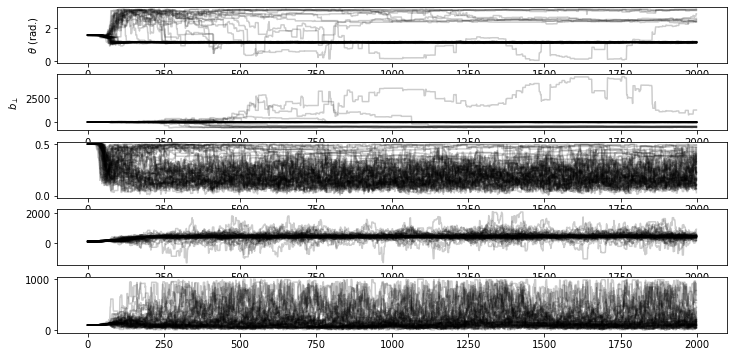

In [350]:
fig, ax = plt.subplots(ndim, 1, figsize=(12, 6))

for i in range(ndim):
    for j in range(nwalkers):
        ax[i].plot(sampler.chain[j,:,i], alpha=0.2, color='k')
        
ax[1].set_xlabel('Iteration')
ax[0].set_ylabel(r'$\theta$ (rad.)')
ax[1].set_ylabel(r'$b_{\perp}$')
        
plt.show()

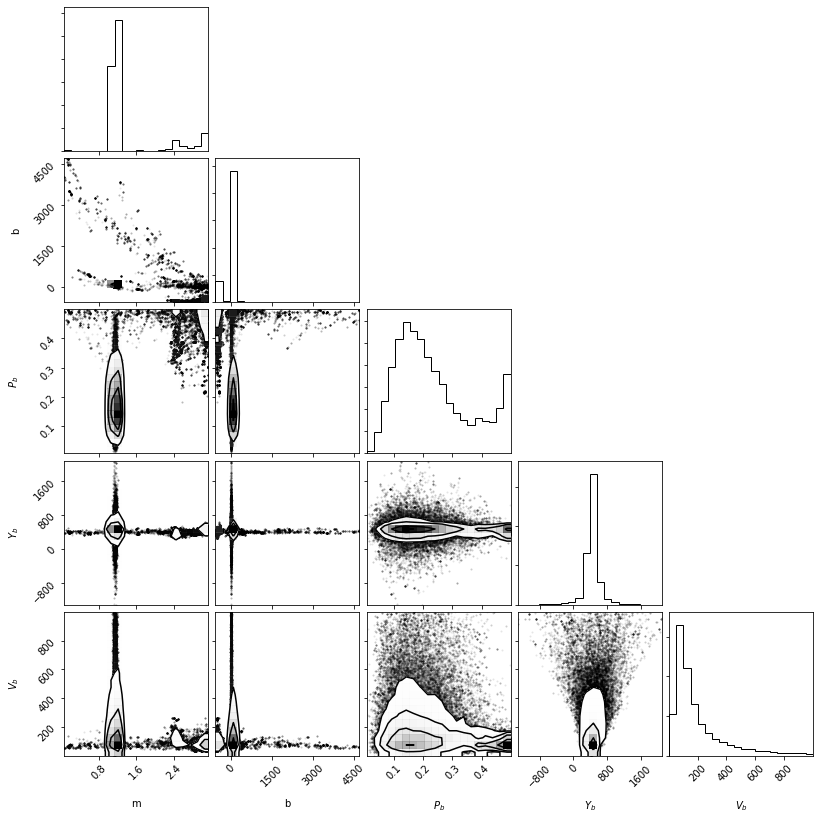

In [351]:
# Remove burn-in
chains = sampler.chain[:,200:]

# Flatten the chains
n_chains, n_steps, n_var = chains.shape
flatchain = chains.reshape((n_chains*n_steps, n_var))

labels = ['m', 'b', r'$P_b$', r'$Y_b$', r'$V_b$']
corner.corner(flatchain, labels=labels)

plt.show()

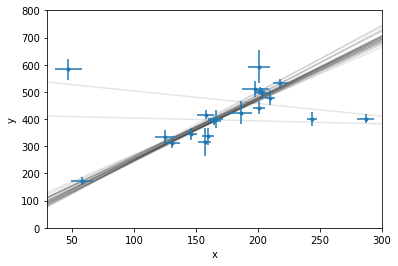

In [354]:
idx = np.random.randint(0, len(flatchain), size=30)
samples = flatchain[idx]

plt.errorbar(data['x'], data['y'], 
             xerr=data['x_err'], yerr=data['y_err'], 
             marker='.', fmt='o', zorder=10)


tmp_x = np.linspace(30, 300, 100)
for sample in samples:
    
    theta, b_perp = sample[0], sample[1]
    m = np.tan(theta)
    b = b_perp / np.cos(theta)
        
    plt.plot(tmp_x, m*tmp_x+b, color='k', alpha=0.1, zorder=1)
    
plt.xlabel('x')
plt.ylabel('y')

plt.xlim(30, 300)
plt.ylim(0, 800)


plt.show()

### Discuss with your partner what you've found

Try initializing your model at a few different points